# Artifact 1: Networkx Basics

## What is a network?

Simply put, a network is a map that shows us how different objects are related to each other.

Let’s take a look at one example, using a python library called NetworkX:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

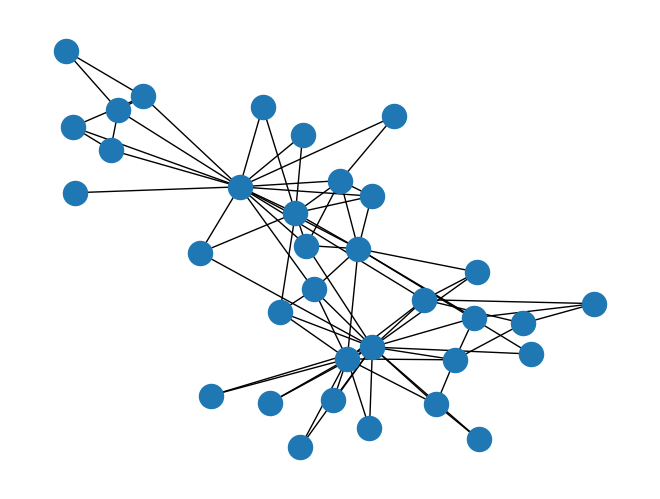

In [2]:
#import the Zachary's karate club network data from NetworkX
karate = nx.karate_club_graph() 
karate_layout = nx.spring_layout(karate,seed=5)

nx.draw(karate,karate_layout)

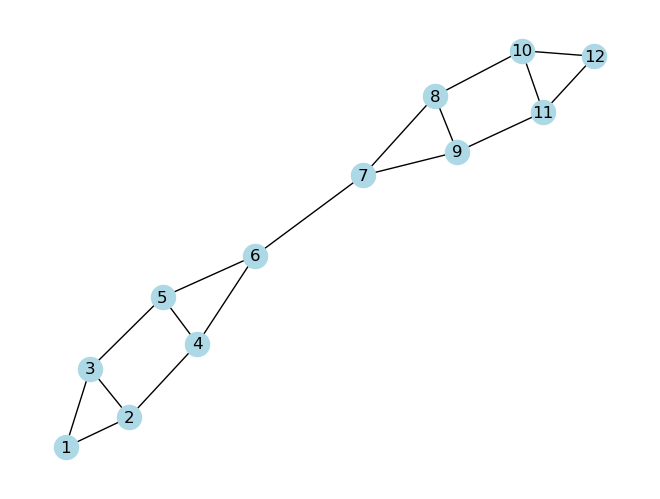

In [3]:
#initialize a new graph
network = nx.Graph() 

#add a set of nodes numbered 1 through 12
network.add_nodes_from(range(1,13)) 
edgelist = [(1,2), 
            (1,3),
            (2,3),
            (2,4),
            (3,5),
            (4,5),
            (4,6),
            (5,6),
            (6,7),
            (7,8),
            (7,9),
            (8,9),
            (8,10),
            (9,11),
            (10,11),
            (10,12),
            (11,12)]

#add a set of links or edges to form a network
network.add_edges_from(edgelist) 

#fix the position
positions = nx.spring_layout(network,seed=10) 
nx.draw(network,positions,node_color="lightblue",with_labels=True)

### Network from Real World Data

Now let's create a network with a more complex dataset. Below, we can find two .csv data files on star wars characters, and their links to star wars scenes. 

In [4]:
nodes = pd.read_csv("starwars-characters.csv",index_col=0)

In [5]:
nodes.head()

,name,scenes
number,,
0,DARTH VADER,190
1,R2-D2,171
2,CHEWBACCA,145
3,BB-8,40
4,QUI-GON,62


In [6]:
edges = pd.read_csv("starwars-links.csv")

In [7]:
edges.head()

,character1,character2,scenes
0,0,1,32
1,2,0,2
2,0,20,5
3,0,4,22
4,0,18,41


In [8]:
G = nx.Graph()

In [9]:
G.add_nodes_from(nodes.index)

In [10]:
for index, row in edges.iterrows():
    G.add_edge(row['character1'], row['character2'], weight=row['scenes'])

In [11]:
# Adjust k for optimal distance
pos = nx.spring_layout(G, k=0.20, iterations=20)  

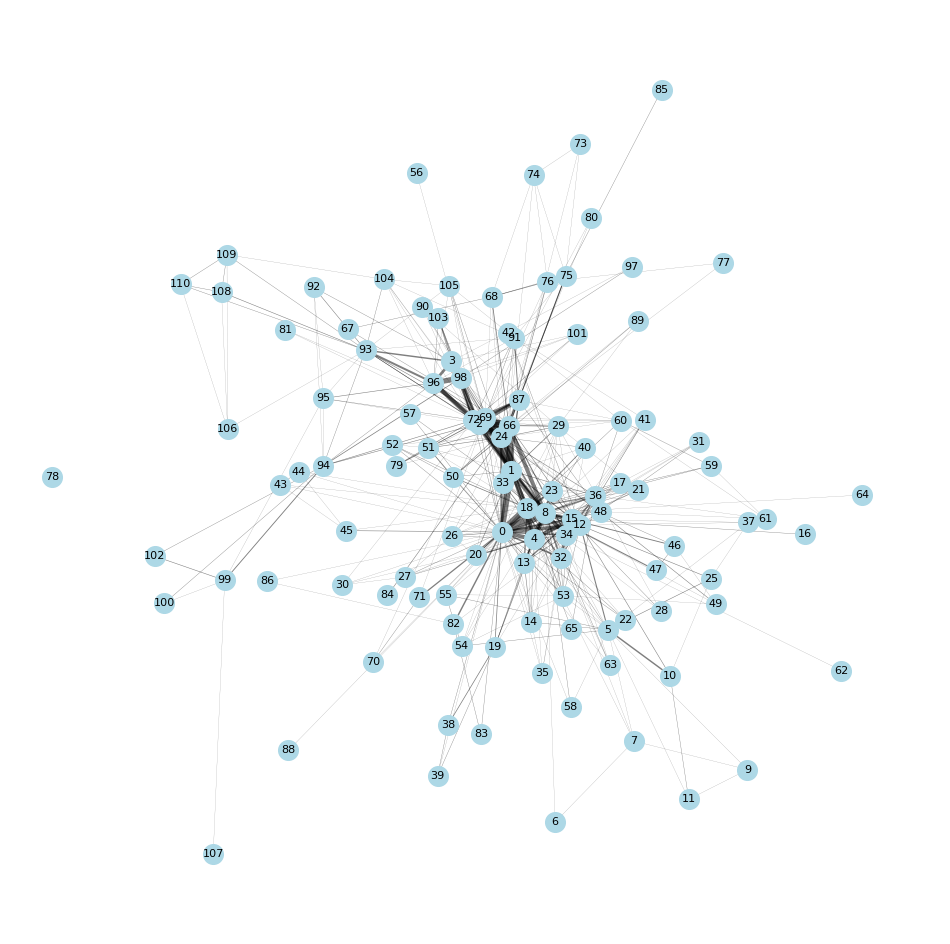

In [12]:
weights = [G[u][v]['weight'] for u, v in G.edges()]

# Normalising the edge weights for a better visualisation
weight_scale = [w * 10 / max(weights) for w in weights]

plt.figure(figsize=(12, 12))

# Customise node size
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=200)  

# Customise edge size
nx.draw_networkx_edges(G, pos, alpha=0.5, width=weight_scale)  

# Customise font size
nx.draw_networkx_labels(G, pos, font_size=8)  

plt.axis('off')
plt.show()

The edge thickness gives infomation on the number of scenes performed by two characters together. Thicker edge signifies that the two characters have been part of more scenes. It's hard to get much information about the graph, just by looking at it. Let's gather tools to analyze this network.

## Degree

If you’re looking at a real network, a natural question to ask is, “who has the most links?”

In an undirected network, the **degree** of a node is the number of connections that node has.

In [13]:
deg = network.degree()
print(deg)

[(1, 2), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 2)]


The total number of links in the network is called the **degree of the network**. In this case, our example network has a degree of 17.

If we wanted to know the total number of links that would be possible in an undirected network with n nodes, we can use the simple formula $ \frac{1}{2}n*(n-1) $ to find it. 

If we divide the degree of a network by the maximum possible degree, it gives us a measure called the **density** of the graph. If a network has a density that is very close to 1, then we would call the network **dense**. On the other hand, if the density is closer to 0, we would call the network **sparse**. In general, dense networks give us more information. However, sparse networks can be valuable because they provide a lot of computational benefits.

Density tells us a little bit about the structure of the network. But there is a lot more that we can examine, just by using degrees. For example, we can draw a histogram of all the nodes with each degree:

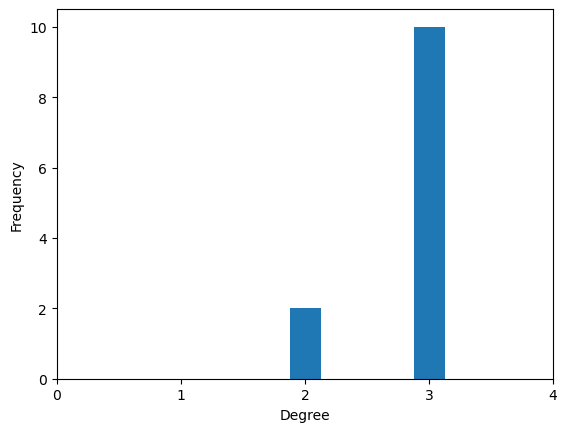

In [14]:
plt.bar(*np.unique([d for n,d in deg], return_counts=True),width=0.25)
plt.xticks([0,1,2,3,4]);
plt.xlabel("Degree");
plt.ylabel("Frequency");

This agrees with our guess. Nodes 1 and 12 each have degree 2, while the remaining 10 nodes have 3 links each.

The distribution of degrees each node has is called its **degree distribution**, and is an easy way to get a feeling for the structure of your network. If every node had the same degree, we would call the network **regular**.

On the other hand, real world networks tend to be more complex. For example, let’s take a look at the degree distribution for the Zachary’s Karate Club network:

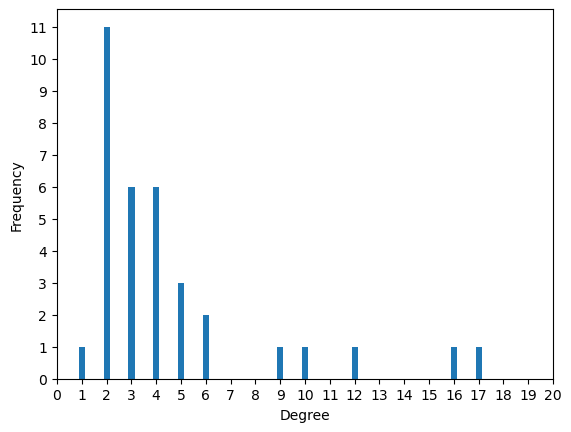

In [15]:
deg = karate.degree()
plt.bar(*np.unique([d for n,d in deg], return_counts=True),width=0.25)
plt.xticks(range(0,21));
plt.yticks(range(0,12));
plt.xlabel("Degree");
plt.ylabel("Frequency");

How does the **degree distribution** on our star wars graph look like?

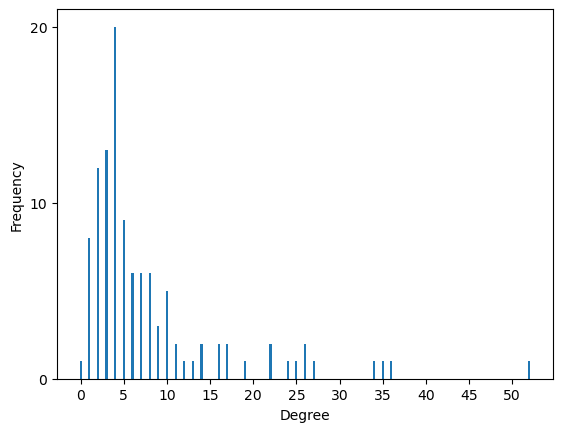

In [16]:
deg = G.degree()
degrees, counts = np.unique([d for n, d in deg], return_counts=True)
plt.bar(degrees, counts, width=0.25)
plt.xticks(range(0, max(degrees) + 1, 5));
plt.yticks(range(0, max(counts) + 1, 10));
plt.xlabel("Degree");
plt.ylabel("Frequency");

The degree distribution is not normal. Instead, the distribution is skewed, and there is one node with >50 degree than the rest. This makes sense. 

Our star wars dataset is more complex but it follows the same distribution pattern as that of Zachary’s Karate Club network.

## Spectral graph theory

### Eigenvector centrality

Often when dealing with network data, a natural question to ask is which node in the network is the most central, or most important. A metric that ranks each node by its importance is called a **centrality measure**.

In fact, we have already discussed one way to do this, called **degree centrality**. If all that is important in your network is how many links a node has, then looking at the degree distribution might give you a good idea of where to find the most central nodes. For example, in the karate club network, there were two nodes who had a much higher degree than the others. It might be natural to guess that these two nodes are the most influential.

Degree centrality, however, often does not tell the whole story. For example, lets revisit our example network. Here, we’ll color every node by their degree centrality, with lighter colors indicating higher centrality.

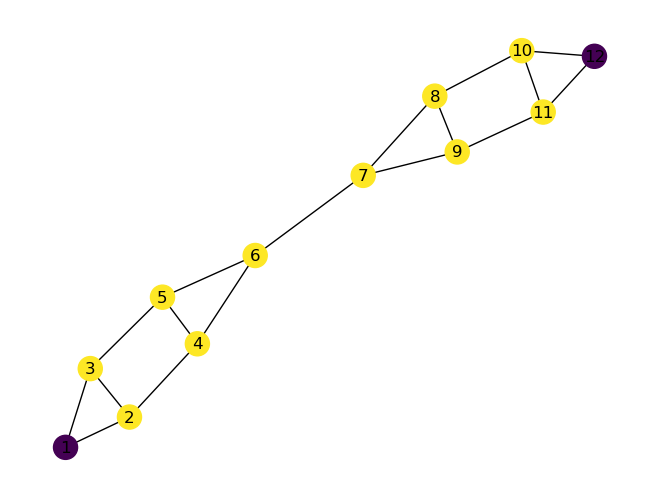

In [17]:
degrees = network.degree() 
degree_colors = [degrees[i] for i in range(1,13)]
nx.draw(network,positions,node_color=degree_colors,with_labels=True)

In this network, almost every node has the same degree. So if we wanted to know which nodes were the most important, number of connections alone would not really give us much useful information.

Another idea, when trying to work out which nodes are the most influential, might accomodate some kind of “popularity effect”. Think about online social networks. If you want to learn how popular someone is, you might glance through their friends list. If they have a lot of friends, but their friends don’t seem very popular, then they might not be so influential. But if they are friends with Leonardo DiCaprio and the pope, you might get the idea that they are a pretty powerful person, even if they don’t have that many friends in total.

So a node is important if it is connected to other important nodes, who are themselves important because they are also connected to important nodes, and so on. It seems like this line of reasoning might just go on forever. But actually, it doesn’t. To see why, let’s try to formalize this idea mathematically. Let’s imagine that there is some number $ x_i $ that represents the centrality of a node $ i $.

Further, we’ll say that the centrality of a node is proportional to the sum of centralities of its neighbors, with some constant of proportionality; let’s call that constant $ \frac{1}{\mu} $.

Remember that the adjacency matrix is a matrix where $ A_{ij} = 1 $ if nodes $ i $ and $ j $ are connected, and $ A_{ij}=0 $ otherwise. Then we can write an expression for the centrality of a node $ i $ as:

$$
x_i = \frac{1}{\mu} \sum_{j=1}^n A_{ij} x_j
$$

If we stack these centrality measures $ x_i $ into a vector $ x $, the result will be a vector whose entries each correspond with the inner product of a row from a matrix with another vector. This is a roundabout way of saying, we can rewrite this equation as:

$$
x = \frac{1}{\mu} Ax
$$

or

$$
A x = \mu x
$$

It turns out that this measure of centrality, which we have constructed based on an argument about “popularity” as being the condition of being connected to other “popular” things, corresponds exactly with an eigenvector of the adjacency matrix! This measure is called **eigenvector centrality**. Eigenvector centrality can usually tell us a lot more about the distribution of influence than degree alone. To see, let’s try it out on our toy network. First, we’ll use `nx.eigenvector_centrality()`

In [18]:
centrality = nx.eigenvector_centrality(network)
print(centrality)

{1: 0.18534426214696834, 2: 0.26793425519264535, 3: 0.26793425519264535, 4: 0.32137618934240997, 5: 0.32137618934240997, 6: 0.33985977126665573, 7: 0.3398597712666558, 8: 0.32137618934241, 9: 0.32137618934241, 10: 0.2679342551926454, 11: 0.2679342551926454, 12: 0.1853442621469684}


The first thing we might notice here is that it’s no longer the same situation as the degree; there is a lot more variance in the eigenvector centrality measure. Let’s visualize this by coloring nodes according to their eigenvector centrality, with lighter colors corresponding to higher centrality.

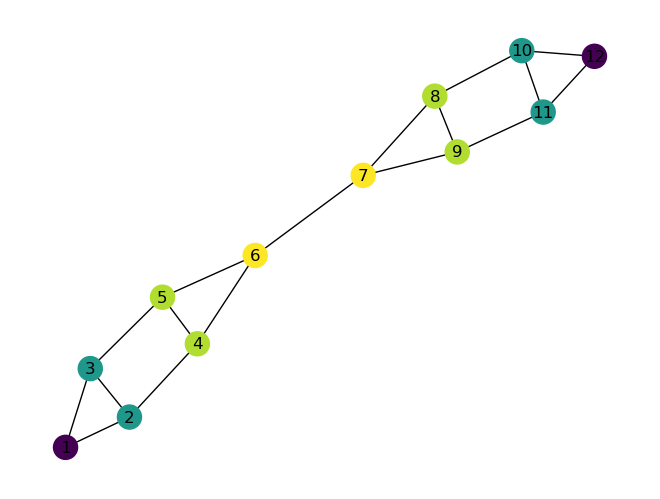

In [19]:
cent_colors = [centrality[i] for i in range(1,13)] 
nx.draw(network,positions,node_color=cent_colors,with_labels=True)

As we suspected, considering influence as being the result of connections with other influential friends gives us a centrality measure that looks way more informative. Nodes that appear to be in “central” positions are indeed considered more “central”, while nodes that are further from the center have lower centrality.

There is no “perfect” centrality measure that always gives the best ranking of nodes in a network, it always depends on the problem you are trying to use networks to solve. An important real-word application of eigenvector centrality is the PageRank algorithm built by the founders of Google, Larry page and Sergey Brin, to rank websites based on their relevance. Eigenvector centrality is cool!

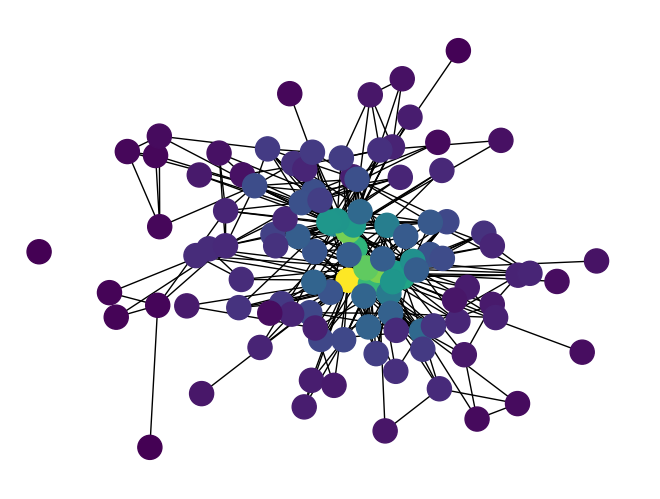

In [20]:
eigen_cent = nx.eigenvector_centrality(G)
eigen_colors = [eigen_cent[i] for i in range(0,111)]
nx.draw(G,pos,node_color=eigen_colors)

In [32]:
nodes_df = pd.read_csv("starwars-characters.csv", index_col=0)

max_cent = max(eigen_cent.values())
min_cent = min(eigen_cent.values())

# Find the most and least central nodes
most_central_nodes = [node for node, centrality in eigen_cent.items() if centrality == max_cent]
least_central_nodes = [node for node, centrality in eigen_cent.items() if centrality == min_cent]

# Find character names for those nodes
most_central_names = nodes_df.loc[most_central_nodes, 'name'].values.tolist()
least_central_names = nodes_df.loc[least_central_nodes, 'name'].values.tolist()

In [33]:
print(f"Most Central Character: Node {most_central_nodes[0]}, {most_central_names[0]}")
print(f"Least Central Character: Node {least_central_nodes[0]}, {least_central_names[0]}")

Most Central Character: Node 0, DARTH VADER
Least Central Character: Node 78, GOLD FIVE


This makes sense since Darth Vader has the most number of links, and has appeared in the most number of scenes. On the other hand, Gold Five is the only character with no links with any other character. Hence, its the least central.

## References

- Chatox. Networks Science Course: Star Wars Data [starwars-characters.csv, starwars-links.csv]. GitHub repository. [https://github.com/chatox/networks-science-course/tree/master/practicum/data/starwars](https://github.com/chatox/networks-science-course/tree/master/practicum/data/starwars)
- Karate Club Network inspiration: Chatox. Networks Science Course: Karate Club. GitHub repository. [https://github.com/chatox/networks-science-course/tree/master/practicum/data/karate-club](https://github.com/chatox/networks-science-course/tree/master/practicum/data/karate-club)
- NetworkX Developers. NetworkX Reference Documentation [Software documentation]. NetworkX. [https://networkx.org/documentation/stable/reference/index.html](https://networkx.org/documentation/stable/reference/index.html)
- Newman, Mark. (2018). *Networks*, 2nd ed. Oxford: Oxford University Press. [Online edition](https://doi.org/10.1093/oso/9780198805090.001.0001), accessed 12 Apr. 2024.

- Newman, Mark. (2018). "Measures and Metrics." In *Networks* (2nd ed.). Oxford University Press. [Online edition](https://doi.org/10.1093/oso/9780198805090.003.0007), accessed 14 Apr. 2024.

- OpenAI. ChatGPT [Software]. Available from https://openai.com/chatgpt

